<a href="https://colab.research.google.com/github/VanHoann/Yelp_Dataset_Challenges/blob/main/Recommendation_Prediction/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import os
from collections import Counter
from itertools import combinations
import random
import numpy as np
import pandas as pd
import tensorflow 
from tensorflow.keras.layers import Concatenate, Dense, Dot, Dropout, Embedding, Input, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import keras
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler #normalize some features

# Setting random seeds to replicate results easily
random.seed(0)
np.random.seed(0)
tensorflow.random.set_seed(0)

# Data Preprocessing
Utility functions that helps us retrieve the numerical values of different features from the dataset, and generate combinations of features to be used by the WDL model.

# Load train, valid, test data (core)

In [3]:
data = "https://raw.githubusercontent.com/VanHoann/Yelp_Dataset_Challenges/main/Recommendation_Prediction/data"
tr_df = pd.read_csv(f"{data}/train.csv")
val_df = pd.read_csv(f"{data}/valid.csv")
te_df = pd.read_csv(f"{data}/test.csv")

tr_ratings = tr_df['stars'].values
val_ratings = val_df['stars'].values

In [4]:
print(tr_df.shape, val_df.shape, te_df.shape)
print(tr_df[:1])

(60080, 3) (7509, 3) (7509, 3)
                            user_id                       business_id  stars
0  7cf33b34bb6ffe993c5f208222860eb3  16d09ff5f22e701e1b729b74f565f825    4.0


# Load users and items (supplement)

In [5]:
user_df = pd.read_csv(f"{data}/user.csv", index_col=0)
item_df = pd.read_csv(f"{data}/business.csv", index_col=0)
user_df = user_df.rename(index=str) 
item_df = item_df.rename(index=str)

##User info

In [7]:
print(user_df.shape)
print(user_df.loc['1'])

(2980, 21)
user_id               9de9e40b3727c667a5b7c1664aa59a5b
name                                             Bobby
review_count                                       376
yelping_since                      2010-03-10 23:55:33
useful                                            1754
funny                                             1036
cool                                              1124
elite                    2013,2014,2015,2016,2017,2018
fans                                                39
average_stars                                     3.64
compliment_hot                                      47
compliment_more                                      6
compliment_profile                                   2
compliment_cute                                      2
compliment_list                                      1
compliment_note                                     38
compliment_plain                                    77
compliment_cool                                    106

##Item info

In [8]:
print(item_df.shape)
print(item_df.loc['1'])

(5964, 14)
business_id                      334a85d83ec4545b5b2b4581e5182c47
name                                 Nee House Chinese Restaurant
address                                13843 N Tatum Blvd, Ste 15
city                                                      Phoenix
state                                                          AZ
postal_code                                                 85032
latitude                                                 33.61302
longitude                                             -111.977036
stars                                                         3.5
review_count                                                  269
is_open                                                         1
attributes      {'Caters': 'True', 'GoodForKids': 'True', 'Noi...
categories                                   Chinese, Restaurants
hours           {'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...
Name: 1, dtype: object


## Nested columns info

### 'item_hours'

In [9]:
print(type(item_df.loc['0']['hours']))
print(item_df.loc['10']['hours'])
print(item_df.loc['100']['hours'])
print(item_df.loc['1000']['hours'])

<class 'str'>
{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', 'Wednesday': '11:0-22:0', 'Thursday': '11:0-22:0', 'Friday': '11:0-23:0', 'Saturday': '11:0-23:0', 'Sunday': '11:0-0:0'}
{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0', 'Wednesday': '11:0-22:0', 'Thursday': '11:0-22:0', 'Friday': '11:0-23:0', 'Saturday': '10:30-23:0', 'Sunday': '10:30-22:0'}
{'Monday': '10:30-21:0', 'Tuesday': '10:30-21:0', 'Wednesday': '10:30-21:0', 'Thursday': '10:30-21:0', 'Friday': '10:30-21:0', 'Saturday': '10:30-21:0', 'Sunday': '11:0-20:0'}


### 'item_attributes'

In [10]:
print(type(item_df.loc['0']['attributes']))
print(item_df.loc['0']['attributes'])
print(item_df.loc['10']['attributes'])
print(item_df.loc['50']['attributes'])
print(item_df.loc['100']['attributes'])
print(item_df.loc['500']['attributes'])
print(item_df.loc['1000']['attributes'])
print(item_df.loc['5000']['attributes'])

<class 'str'>
{'CoatCheck': 'False', 'BusinessParking': "{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}", 'HappyHour': 'True', 'Smoking': "u'no'", 'WiFi': "u'free'", 'RestaurantsTableService': 'False', 'RestaurantsDelivery': 'False', 'Alcohol': "u'full_bar'", 'RestaurantsPriceRange2': '2', 'HasTV': 'False', 'Caters': 'True', 'Music': "{'dj': False, 'background_music': True, 'jukebox': False, 'live': False, 'video': False, 'karaoke': False}", 'RestaurantsTakeOut': 'True', 'BestNights': "{'monday': False, 'tuesday': False, 'friday': True, 'wednesday': True, 'thursday': True, 'sunday': False, 'saturday': False}", 'WheelchairAccessible': 'True', 'BusinessAcceptsCreditCards': 'True', 'GoodForKids': 'False', 'BusinessAcceptsBitcoin': 'False', 'GoodForDancing': 'False', 'BikeParking': 'True', 'RestaurantsAttire': "u'casual'", 'RestaurantsGoodForGroups': 'True', 'NoiseLevel': "u'average'", 'RestaurantsReservations': 'False', 'Ambience': "{'romantic': False,

#### nested attributes

Inside 'item_attributes': 'BusinessParking', 'GoodForMeal', 'Ambience', 'BestNights', 'Music' have their own attributes


# Extract item_attributes

These features will be considered:
* NoiseLevel
* RestaurantsAttire
* RestaurantsTakeOut
* RestaurantsReservations
* RestaurantsDelivery
* Alcohol
* RestaurantsPriceRange2
* BikeParking
* HappyHour
* OutdoorSeating
* RestaurantsGoodForGroups
* HasTV
* Caters
* GoodForKids
* BusinessAcceptsCreditCards
* WiFi
* GoodForDancing
* Smoking
* RestaurantsTableService
* BYOBCorkage
* CoatCheck

-> Create a vocab of possible vals of each feat listed above. \
-> A corresponding id val will map to each val in its vocab. 

Note that not every business has all listed feats \
-> Give NaN to the missing feat of a restaurant and map to index 0 in a feat’s vocabulary. The same was done for the other cate feats.

In [11]:
import json
import ast
import csv
from tqdm import tqdm
import numpy as np

Parse 'item_hours' and 'item_attributes'

In [12]:
for i in range(10):
  print(item_df['hours'][i])

{'Wednesday': '17:0-0:0', 'Thursday': '17:0-0:0', 'Friday': '17:0-0:0', 'Saturday': '17:0-0:0', 'Sunday': '17:0-0:0'}
{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21:0', 'Thursday': '11:0-21:0', 'Friday': '11:0-21:30', 'Saturday': '11:0-21:30', 'Sunday': '11:0-21:30'}
{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0', 'Wednesday': '11:0-22:0', 'Thursday': '11:0-22:0', 'Friday': '11:0-0:0', 'Saturday': '11:0-0:0', 'Sunday': '10:0-22:0'}
{'Monday': '0:0-0:0', 'Tuesday': '9:0-15:0', 'Wednesday': '9:0-14:0', 'Thursday': '11:0-16:0', 'Friday': '9:0-15:0', 'Saturday': '9:0-15:0', 'Sunday': '9:0-16:0'}
{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21:0', 'Thursday': '11:0-21:0', 'Friday': '11:0-21:0', 'Saturday': '11:0-21:0', 'Sunday': '11:0-21:0'}
{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0', 'Wednesday': '11:0-22:0', 'Thursday': '11:0-22:0', 'Friday': '11:0-22:0', 'Saturday': '11:0-22:0', 'Sunday': '11:0-20:0'}
{'Monday': '16:0-0:0', 'Tuesday': '16:

In [13]:
for i in range(10):
  print(item_df['attributes'][i])

{'CoatCheck': 'False', 'BusinessParking': "{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}", 'HappyHour': 'True', 'Smoking': "u'no'", 'WiFi': "u'free'", 'RestaurantsTableService': 'False', 'RestaurantsDelivery': 'False', 'Alcohol': "u'full_bar'", 'RestaurantsPriceRange2': '2', 'HasTV': 'False', 'Caters': 'True', 'Music': "{'dj': False, 'background_music': True, 'jukebox': False, 'live': False, 'video': False, 'karaoke': False}", 'RestaurantsTakeOut': 'True', 'BestNights': "{'monday': False, 'tuesday': False, 'friday': True, 'wednesday': True, 'thursday': True, 'sunday': False, 'saturday': False}", 'WheelchairAccessible': 'True', 'BusinessAcceptsCreditCards': 'True', 'GoodForKids': 'False', 'BusinessAcceptsBitcoin': 'False', 'GoodForDancing': 'False', 'BikeParking': 'True', 'RestaurantsAttire': "u'casual'", 'RestaurantsGoodForGroups': 'True', 'NoiseLevel': "u'average'", 'RestaurantsReservations': 'False', 'Ambience': "{'romantic': False, 'intimate': F

# Generate full_business.csv

In [15]:
def parse_data(source, output_path):
    # setup an array for writing each row in the csv file
    rows = []
    # extract fields from business.csv
    # setup an array for storing each csv entry
    business_data = []
    # setup an array for headers we are not using strictly
    removed_header = ['hours', 'attributes']
    # setup an array for headers we are adding
    business_header_additions = [# item_hours
                                 'Sunday_Open', 'Sunday_Close', 'Monday_Open', 'Monday_Close', 'Tuesday_Open',
                                 'Tuesday_Close', 'Wednesday_Open', 'Wednesday_Close', 'Thursday_Open',
                                 'Thursday_Close', 'Friday_Open', 'Friday_Close', 'Saturday_Open', 'Saturday_Close',
                                 # item_attributes
                                 'NoiseLevel', 'RestaurantsAttire', "RestaurantsTakeOut", 'RestaurantsReservations',
                                 'RestaurantsDelivery', 'Alcohol','RestaurantsPriceRange2', 'BikeParking',
                                 'HappyHour', 'OutdoorSeating','RestaurantsGoodForGroups',
                                 'HasTV', 'Caters', 'GoodForKids', 'BusinessAcceptsCreditCards',
                                 'WiFi', 'GoodForDancing', 'Smoking', 'RestaurantsTableService', 'BYOBCorkage', 'CoatCheck',
                                 # BusinessParking in item_attributes
                                 'Parking_Street', 'Parking_Valet', 'Parking_Lot', 'Parking_Garage', 'Parking_Validated',
                                 # GoodForMeal in item_attributes
                                 'GoodFor_dessert', 'GoodFor_latenight', 'GoodFor_lunch', 'GoodFor_dinner', 'GoodFor_brunch', 'GoodFor_breakfast',
                                 # Ambience in item_attributes
                                 'Ambience_romantic', 'Ambience_intimate', 'Ambience_classy', 'Ambience_hipster',
                                 'Ambience_divey', 'Ambience_touristy', 'Ambience_trendy', 'Ambience_upscale', 'Ambience_casual',
                                 # Music in item_attributes
                                 'Music_dj', 'Music_background_music', 'Music_jukebox', 'Music_live', 'Music_video', 'Music_karaoke',
                                 # BestNights in item_attributes
                                 'BestNights_monday', 'BestNights_tuesday', 'BestNights_friday', 'BestNights_wednesday',
                                 'BestNights_thursday', 'BestNights_sunday', 'BestNights_saturday']
                                 
    numData = item_df.shape[0]
    for i in range(numData):
              business_data.append(item_df.loc[str(i)])
    # append the initial keys as csv headers
    header = sorted(business_data[0].keys()) 
    for h in removed_header:
        header.remove(h)
    orig_header = header

    print('processing data in the business dataset...')
    # for each entry
    # count for an interested attribute
    interested = "HasTV"
    true_count = 0
    false_count = 0
    nonTFval_count = 0
    nan_count = 0
    for entry in tqdm(range(0, len(business_data))):
        row = []
        # keep other columns
        for item in orig_header:
            if item not in removed_header:
                row.append(business_data[entry][item])


        # Extract 'item_hours':
        curr_dict = {}
        source = business_data[entry]['hours'] # str
        output = "" # convert '' to "" for JSON
        if str(source) != 'nan':
            for char in source:
                if char == "'":
                    output += '"'
                else:
                    output += char
            curr_dict = json.loads(output)

        days_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
        # iterate through the days of the week to extract the open and close times
        for time in days_of_week:
            # if a time is available
            if len(curr_dict) != 0:
                if time in curr_dict.keys():
                    # append the open time
                    row.append(curr_dict[time].split('-')[0])
                    # append the closing time
                    row.append(curr_dict[time].split('-')[1])
                # else if a time is not available
                else:
                    # append NA for the open time
                    row.append(np.nan)
                    # append NA for the closing time
                    row.append(np.nan)
            else:
                # append NA for the open time
                row.append(np.nan)
                # append NA for the closing time
                row.append(np.nan)

        
        # Extract 'item_attributes':
        curr_dict = {}
        source = business_data[entry]['attributes'] # str
        if str(source) != 'nan':
            curr_dict = ast.literal_eval(source) # convert str to dict

        attributes = ['NoiseLevel', 'RestaurantsAttire', "RestaurantsTakeOut", 'RestaurantsReservations',
                      'RestaurantsDelivery', 'Alcohol','RestaurantsPriceRange2', 'BikeParking',
                      'HappyHour', 'OutdoorSeating','RestaurantsGoodForGroups',
                      'HasTV', 'Caters', 'GoodForKids', 'BusinessAcceptsCreditCards',
                      'WiFi', 'GoodForDancing', 'Smoking', 'RestaurantsTableService', 'BYOBCorkage', 'CoatCheck']
        # for each attribute that is not nested //they are T,F or categorical features
        for attribute in attributes:
            # if there is an attribute
            if len(curr_dict) != 0:
                if attribute in curr_dict.keys():
                    # if the attribute contains true
                    if curr_dict[attribute] == "True":
                        row.append(1)
                        if attribute == interested:
                            true_count +=1
                    # else if the attribute contains false
                    elif curr_dict[attribute] == "False":
                        row.append(0)
                        if attribute == interested:
                            false_count +=1
                    # else if the attribute is non-empty and not true of false i.e. other types or nested
                    elif curr_dict[attribute] is not None:
                        # attribute's val != TF
                        if attribute == interested:
                            nonTFval_count +=1
                        row.append(str(curr_dict[attribute]).replace('u', ''))
                    else: 
                        # attribute's val = NaN
                        row.append(np.nan)
                        if attribute == interested:
                            nan_count +=1
                else: # attribute not in item_attributes
                    row.append(np.nan)
                    if attribute == interested:
                        nan_count +=1
            else: # item_attributes not exist
                row.append(np.nan)
                if attribute == interested:
                    nan_count +=1

        # nested attributes: 'BusinessParking', 'GoodForMeal', 'Ambience', 'BestNights', 'Music'
        # extract the parking attributes
        parking_attributes = ['street', 'valet', 'lot', 'garage', 'validated']
        # for each parking attribute
        for attribute in parking_attributes:
            # if there is an attribute
            if len(curr_dict) != 0:
                if 'BusinessParking' in curr_dict.keys() and curr_dict['BusinessParking'] != 'None':
                    nested_dict = ast.literal_eval(curr_dict['BusinessParking']) # convert str to dict
                    # if the parking attribute exists
                    if attribute in nested_dict.keys():
                        # if the parking attribute is true
                        if nested_dict[attribute] == True:
                            row.append(1)
                        # if the parking attribute is false
                        elif nested_dict[attribute] == False:
                            row.append(0)
                        # note that the parking attributes are all true/false so no need for is not None elif
                    # else if the specific attribute is not available
                        else:
                            row.append(np.nan)
                    else:
                        row.append(np.nan)
                # else if the parking attribute is not availablestr(item).replace('\n', ' ')
                else:
                    row.append(np.nan)
            else:
                row.append(np.nan)

        # extract the GoodForMeal attributes
        GoodFor_attributes = ['dessert', 'latenight', 'lunch', 'dinner', 'brunch', 'breakfast']
        # for each GoodFor attribute
        for attribute in GoodFor_attributes:
            # if there is an attribute
            if len(curr_dict) != 0:
                if 'GoodForMeal' in curr_dict.keys() and curr_dict['GoodForMeal'] != 'None':
                    nested_dict = ast.literal_eval(curr_dict['GoodForMeal']) # convert str to dict
                    # if the GoodFor attribute exists
                    if attribute in nested_dict.keys():
                        # if the GoodFor attribute is true
                        if nested_dict[attribute] == True:
                            row.append(1)
                        # if the GoodFor attribute is false
                        elif nested_dict[attribute] == False:
                            row.append(0)
                        # note that the GoodFor attributes are all true/false so no need for is not None elif
                    # else if the specific attribute is not available
                        else:
                            row.append(np.nan)
                    else:
                        row.append(np.nan)
                # else if the GoodFor attribute is not availablestr(item).replace('\n', ' ')
                else:
                    row.append(np.nan)
            else:
                row.append(np.nan)

        # extract the Ambience attributes
        Ambience_attributes = ['romantic', 'intimate', 'classy', 'hipster', 'divey', 'touristy', 'trendy', 'upscale', 'casual']
        # for each Ambience attribute
        for attribute in Ambience_attributes:
            # if there is an attribute
            if len(curr_dict) != 0:
                if 'Ambience' in curr_dict.keys() and curr_dict['Ambience'] != 'None':
                    nested_dict = ast.literal_eval(curr_dict['Ambience']) # convert str to dict
                    # if the Ambience attribute exists
                    if attribute in nested_dict.keys():
                        # if the Ambience attribute is true
                        if nested_dict[attribute] == True:
                            row.append(1)
                        # if the Ambience attribute is false
                        elif nested_dict[attribute] == False:
                            row.append(0)
                        # note that the Ambience attributes are all true/false so no need for is not None elif
                    # else if the specific attribute is not available
                        else:
                            row.append(np.nan)
                    else:
                        row.append(np.nan)
                # else if the Ambience attribute is not availablestr(item).replace('\n', ' ')
                else:
                    row.append(np.nan)
            else:
                row.append(np.nan)

        # extract the Music attributes
        Music_attributes = ['dj', 'background_music', 'jukebox', 'live', 'video', 'karaoke']
        # for each Music attribute
        for attribute in Music_attributes:
            # if there is an attribute
            if len(curr_dict) != 0:
                if 'Music' in curr_dict.keys() and curr_dict['Music'] != 'None':
                    nested_dict = ast.literal_eval(curr_dict['Music']) # convert str to dict
                    # if the Music attribute exists
                    if attribute in nested_dict.keys():
                        # if the Music attribute is true
                        if nested_dict[attribute] == True:
                            row.append(1)
                        # if the Music attribute is false
                        elif nested_dict[attribute] == False:
                            row.append(0)
                        # note that the Music attributes are all true/false so no need for is not None elif
                    # else if the specific attribute is not available
                        else:
                            row.append(np.nan)
                    else:
                        row.append(np.nan)
                # else if the Music attribute is not availablestr(item).replace('\n', ' ')
                else:
                    row.append(np.nan)
            else:
                row.append(np.nan)

        # extract the BestNights attributes
        BestNights_attributes = ['monday', 'tuesday', 'friday', 'wednesday', 'thursday', 'sunday', 'saturday']
        # for each BestNights attribute
        for attribute in BestNights_attributes:
            # if there is an attribute
            if len(curr_dict) != 0:
                if 'BestNights' in curr_dict.keys() and curr_dict['BestNights'] != 'None':
                    nested_dict = ast.literal_eval(curr_dict['BestNights']) # convert str to dict
                    # if the BestNights attribute exists
                    if attribute in nested_dict.keys():
                        # if the BestNights attribute is true
                        if nested_dict[attribute] == True:
                            row.append(1)
                        # if the BestNights attribute is false
                        elif nested_dict[attribute] == False:
                            row.append(0)
                        # note that the BestNights attributes are all true/false so no need for is not None elif
                    # else if the specific attribute is not available
                        else:
                            row.append(np.nan)
                    else:
                        row.append(np.nan)
                # else if the BestNights attribute is not availablestr(item).replace('\n', ' ')
                else:
                    row.append(np.nan)
            else:
                row.append(np.nan)
        #DONE

        # clean up the row entry
        row_clean = []
        # for every item in the row
        for item in row:
            # scan and replace for nasty text
            row_clean.append(str(item).replace('\n', ' '))
        # after all fields have been extracted and cleaned, append the row to the rows array for writing to csv
        rows.append(row_clean)  

    # for interested attribute      
    print("\n", len(business_data), interested, ":", true_count, "T,", 
          false_count, "F,", nonTFval_count, "nonTFval,", nan_count, "NaN")
    
    #write csv
    for headers in business_header_additions:
        header.append(headers)
    length = len(header)
    
    # write to csv file
    # print(header)
    with open(output_path, 'w') as out:
        writer = csv.writer(out)
        # write the csv headers
        writer.writerow(header)
        # for each entry in the row array
        print('writing contents to csv...')
        for entry in tqdm(range(0, len(rows))):
            try:
                assert(len(rows[entry])==length)
                # write the row to the csv
                writer.writerow(rows[entry])
            # if there is an error, continue to the next row
            except UnicodeEncodeError:
                continue
    out.close()

parse_data('business.csv', 'full_business.csv')


processing data in the business dataset...


100%|██████████| 5964/5964 [00:05<00:00, 1072.90it/s]



 5964 HasTV : 3052 T, 1880 F, 0 nonTFval, 1032 NaN
writing contents to csv...


100%|██████████| 5964/5964 [00:00<00:00, 67396.35it/s]


# Test code
compare business.csv and full_business.csv

In [18]:
item_df = pd.read_csv(f"{data}/business.csv", index_col=0)
item_df = item_df.rename(index=str)
itemfull_df = pd.read_csv("full_business.csv")

## 'item_hours'

In [19]:
item_df.loc['100']['hours']

"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0', 'Wednesday': '11:0-22:0', 'Thursday': '11:0-22:0', 'Friday': '11:0-23:0', 'Saturday': '10:30-23:0', 'Sunday': '10:30-22:0'}"

In [20]:
itemfull_df.loc[100,'Sunday_Open': 'Saturday_Close']

Sunday_Open        10:30
Sunday_Close        22:0
Monday_Open         11:0
Monday_Close        22:0
Tuesday_Open        11:0
Tuesday_Close       22:0
Wednesday_Open      11:0
Wednesday_Close     22:0
Thursday_Open       11:0
Thursday_Close      22:0
Friday_Open         11:0
Friday_Close        23:0
Saturday_Open      10:30
Saturday_Close      23:0
Name: 100, dtype: object

## non-nested 'item_attributes'

In [21]:
keys = ['NoiseLevel', 'RestaurantsAttire', "RestaurantsTakeOut", 'RestaurantsReservations',
        'RestaurantsDelivery', 'Alcohol','RestaurantsPriceRange2', 'BikeParking',
        'HappyHour', 'OutdoorSeating','RestaurantsGoodForGroups',
        'HasTV', 'Caters', 'GoodForKids', 'BusinessAcceptsCreditCards',
        'WiFi', 'GoodForDancing', 'Smoking', 'RestaurantsTableService', 'BYOBCorkage', 'CoatCheck']
curr_dict = ast.literal_eval(item_df.loc['100']['attributes'])
[curr_dict.get(key) for key in keys]

["u'loud'",
 "u'casual'",
 'True',
 'True',
 'False',
 "u'full_bar'",
 '3',
 'False',
 'True',
 'False',
 'True',
 'True',
 'False',
 'False',
 'True',
 "u'free'",
 'False',
 "u'no'",
 'True',
 None,
 'False']

In [22]:
itemfull_df.loc[100,'NoiseLevel': 'CoatCheck']

NoiseLevel                        'lod'
RestaurantsAttire               'casal'
RestaurantsTakeOut                  1.0
RestaurantsReservations             1.0
RestaurantsDelivery                   0
Alcohol                       'fll_bar'
RestaurantsPriceRange2              3.0
BikeParking                           0
HappyHour                           1.0
OutdoorSeating                      0.0
RestaurantsGoodForGroups              1
HasTV                               1.0
Caters                              0.0
GoodForKids                           0
BusinessAcceptsCreditCards            1
WiFi                             'free'
GoodForDancing                      0.0
Smoking                            'no'
RestaurantsTableService             1.0
BYOBCorkage                         NaN
CoatCheck                             0
Name: 100, dtype: object

## nested 'item_attributes'

###'BusinessParking'


In [23]:
keys = ['street', 'valet', 'lot', 'garage', 'validated']
curr_dict = ast.literal_eval(item_df.loc['100']['attributes'])
nested_dict = ast.literal_eval(curr_dict['BusinessParking'])
[nested_dict.get(key) for key in keys]

[False, True, True, False, False]

In [24]:
itemfull_df.loc[100,'Parking_Street': 'Parking_Validated']

Parking_Street       0.0
Parking_Valet        1.0
Parking_Lot          1.0
Parking_Garage       0.0
Parking_Validated    0.0
Name: 100, dtype: object

### 'GoodForMeal'

In [25]:
keys = ['dessert', 'latenight', 'lunch', 'dinner', 'brunch', 'breakfast']
curr_dict = ast.literal_eval(item_df.loc['100']['attributes'])
nested_dict = ast.literal_eval(curr_dict['GoodForMeal'])
[nested_dict.get(key) for key in keys]

[False, False, True, True, True, False]

In [26]:
itemfull_df.loc[100,'GoodFor_dessert': 'GoodFor_breakfast']

GoodFor_dessert      0.0
GoodFor_latenight    0.0
GoodFor_lunch        1.0
GoodFor_dinner       1.0
GoodFor_brunch       1.0
GoodFor_breakfast    0.0
Name: 100, dtype: object

### 'Ambience'

In [27]:
keys = ['romantic', 'intimate', 'classy', 'hipster', 'divey', 'touristy', 'trendy', 'upscale', 'casual']
curr_dict = ast.literal_eval(item_df.loc['100']['attributes'])
nested_dict = ast.literal_eval(curr_dict['Ambience'])
[nested_dict.get(key) for key in keys]

[False, False, False, False, False, False, True, False, False]

In [28]:
itemfull_df.loc[100, 'Ambience_romantic': 'Ambience_casual']

Ambience_romantic    0.0
Ambience_intimate    0.0
Ambience_classy      0.0
Ambience_hipster     0.0
Ambience_divey       0.0
Ambience_touristy    0.0
Ambience_trendy      1.0
Ambience_upscale     0.0
Ambience_casual      0.0
Name: 100, dtype: object

### 'Music' (sparse)

In [29]:
keys = ['dj', 'background_music', 'jukebox', 'live', 'video', 'karaoke']
curr_dict = ast.literal_eval(item_df.loc['0']['attributes'])
nested_dict = ast.literal_eval(curr_dict['Music'])
[nested_dict.get(key) for key in keys]

[False, True, False, False, False, False]

In [30]:
itemfull_df.loc[0, 'Music_dj': 'Music_karaoke']                   

Music_dj                  0.0
Music_background_music    1.0
Music_jukebox             0.0
Music_live                0.0
Music_video               0.0
Music_karaoke             0.0
Name: 0, dtype: object

### 'BestNights'

In [31]:
keys = ['monday', 'tuesday', 'friday', 'wednesday', 'thursday', 'sunday', 'saturday']
curr_dict = ast.literal_eval(item_df.loc['0']['attributes'])
nested_dict = ast.literal_eval(curr_dict['BestNights'])
[nested_dict.get(key) for key in keys]

[False, False, True, True, True, False, False]

In [32]:
itemfull_df.loc[0, 'BestNights_monday': 'BestNights_saturday']                   

BestNights_monday       0.0
BestNights_tuesday      0.0
BestNights_friday       1.0
BestNights_wednesday    1.0
BestNights_thursday     1.0
BestNights_sunday       0.0
BestNights_saturday     0.0
Name: 0, dtype: object

# Data exploration

## Review

In [33]:
print(tr_df[:1], "\n")
print(tr_df.shape, val_df.shape, te_df.shape)
print("In", tr_df.shape[0], "train data:", len(tr_df['user_id'].unique()), "users,",
      len(tr_df['business_id'].unique()), "businesses,", len(tr_df['stars'].unique()), "stars")

                            user_id                       business_id  stars
0  7cf33b34bb6ffe993c5f208222860eb3  16d09ff5f22e701e1b729b74f565f825    4.0 

(60080, 3) (7509, 3) (7509, 3)
In 60080 train data: 2972 users, 5938 businesses, 5 stars


4.0    21300
5.0    20557
3.0    10512
2.0     4780
1.0     2931
Name: stars, dtype: int64


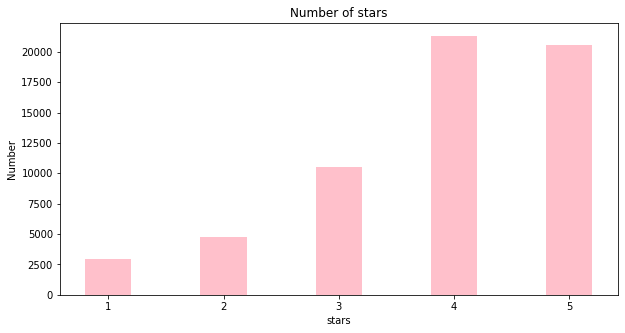

In [34]:
data = dict(tr_df['stars'].value_counts())
print(tr_df['stars'].value_counts())
stars = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(stars, values, color ='pink',
        width = 0.4)
 
plt.xlabel("stars")
plt.ylabel("Number")
plt.title("Number of stars")
plt.savefig('stars.png')
plt.show()

## User

In [35]:
user_df.shape

(2980, 21)

In [36]:
print(user_df.loc['1'])

user_id               9de9e40b3727c667a5b7c1664aa59a5b
name                                             Bobby
review_count                                       376
yelping_since                      2010-03-10 23:55:33
useful                                            1754
funny                                             1036
cool                                              1124
elite                    2013,2014,2015,2016,2017,2018
fans                                                39
average_stars                                     3.64
compliment_hot                                      47
compliment_more                                      6
compliment_profile                                   2
compliment_cute                                      2
compliment_list                                      1
compliment_note                                     38
compliment_plain                                    77
compliment_cool                                    106
compliment

In [37]:
len(user_df['name'].unique())

1428

(array([  1.,   3.,  19.,  44., 134., 384., 993., 931., 389.,  82.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

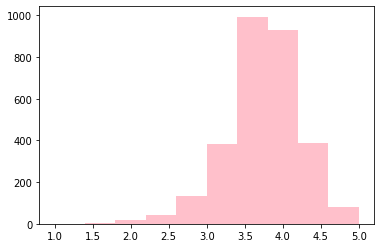

In [38]:
plt.hist(user_df['average_stars'], color='pink')

## Business

In [39]:
item_df.shape

(5964, 14)

In [40]:
print(item_df.loc['1'])

business_id                      334a85d83ec4545b5b2b4581e5182c47
name                                 Nee House Chinese Restaurant
address                                13843 N Tatum Blvd, Ste 15
city                                                      Phoenix
state                                                          AZ
postal_code                                                 85032
latitude                                                 33.61302
longitude                                             -111.977036
stars                                                         3.5
review_count                                                  269
is_open                                                         1
attributes      {'Caters': 'True', 'GoodForKids': 'True', 'Noi...
categories                                   Chinese, Restaurants
hours           {'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...
Name: 1, dtype: object


In [41]:
len(item_df['postal_code'].unique())

798

In [42]:
item_df['is_open'].value_counts()

1    5402
0     562
Name: is_open, dtype: int64

(array([5.605e+03, 2.520e+02, 6.200e+01, 2.300e+01, 1.300e+01, 4.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([ 167. ,  985.1, 1803.2, 2621.3, 3439.4, 4257.5, 5075.6, 5893.7,
        6711.8, 7529.9, 8348. ]),
 <a list of 10 Patch objects>)

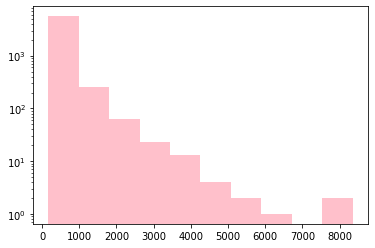

In [43]:
plt.yscale('log')
plt.hist(item_df['review_count'], color='pink')

## Full Business

In [44]:
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
#pd.describe_option('max_colwidth')

In [45]:
itemfull_df.shape

(5964, 80)

In [46]:
itemfull_df.columns

Index(['address', 'business_id', 'categories', 'city', 'is_open', 'latitude',
       'longitude', 'name', 'postal_code', 'review_count', 'stars', 'state',
       'Sunday_Open', 'Sunday_Close', 'Monday_Open', 'Monday_Close',
       'Tuesday_Open', 'Tuesday_Close', 'Wednesday_Open', 'Wednesday_Close',
       'Thursday_Open', 'Thursday_Close', 'Friday_Open', 'Friday_Close',
       'Saturday_Open', 'Saturday_Close', 'NoiseLevel', 'RestaurantsAttire',
       'RestaurantsTakeOut', 'RestaurantsReservations', 'RestaurantsDelivery',
       'Alcohol', 'RestaurantsPriceRange2', 'BikeParking', 'HappyHour',
       'OutdoorSeating', 'RestaurantsGoodForGroups', 'HasTV', 'Caters',
       'GoodForKids', 'BusinessAcceptsCreditCards', 'WiFi', 'GoodForDancing',
       'Smoking', 'RestaurantsTableService', 'BYOBCorkage', 'CoatCheck',
       'Parking_Street', 'Parking_Valet', 'Parking_Lot', 'Parking_Garage',
       'Parking_Validated', 'GoodFor_dessert', 'GoodFor_latenight',
       'GoodFor_lunch', 'GoodFor

In [47]:
itemfull_df.loc[10, 'Sunday_Open':]                   

Sunday_Open                        11:0
Sunday_Close                        0:0
Monday_Open                         0:0
Monday_Close                        0:0
Tuesday_Open                       11:0
Tuesday_Close                      22:0
Wednesday_Open                     11:0
Wednesday_Close                    22:0
Thursday_Open                      11:0
Thursday_Close                     22:0
Friday_Open                        11:0
Friday_Close                       23:0
Saturday_Open                      11:0
Saturday_Close                     23:0
NoiseLevel                    'average'
RestaurantsAttire               'casal'
RestaurantsTakeOut                  1.0
RestaurantsReservations             1.0
RestaurantsDelivery                   1
Alcohol                       'fll_bar'
RestaurantsPriceRange2              2.0
BikeParking                           1
HappyHour                           NaN
OutdoorSeating                      1.0
RestaurantsGoodForGroups              1


## NaN values

In [48]:
print(tr_df.shape)
print(tr_df.isna().sum())

(60080, 3)
user_id        0
business_id    0
stars          0
dtype: int64


In [49]:
print(user_df.shape)
print(user_df.isna().sum())

(2980, 21)
user_id                  0
name                     0
review_count             0
yelping_since            0
useful                   0
funny                    0
cool                     0
elite                 1636
fans                     0
average_stars            0
compliment_hot           0
compliment_more          0
compliment_profile       0
compliment_cute          0
compliment_list          0
compliment_note          0
compliment_plain         0
compliment_cool          0
compliment_funny         0
compliment_writer        0
compliment_photos        0
dtype: int64


In [50]:
for column_name in user_df.columns:
    column = user_df[column_name]
    count = (column == 0).sum()
    print(column_name, ':', count)

user_id : 0
name : 0
review_count : 0
yelping_since : 0
useful : 3
funny : 38
cool : 18
elite : 0
fans : 572
average_stars : 0
compliment_hot : 1416
compliment_more : 1653
compliment_profile : 2267
compliment_cute : 2392
compliment_list : 2616
compliment_note : 829
compliment_plain : 750
compliment_cool : 1089
compliment_funny : 1089
compliment_writer : 1217
compliment_photos : 1758


In [51]:
print(item_df.shape)
print(item_df.isna().sum())

(5964, 14)
business_id       0
name              0
address          29
city              0
state             0
postal_code       0
latitude          0
longitude         0
stars             0
review_count      0
is_open           0
attributes       53
categories        0
hours           120
dtype: int64


In [52]:
print(itemfull_df.shape)
print(itemfull_df.isna().sum())

(5964, 80)
address                         29
business_id                      0
categories                       0
city                             0
is_open                          0
latitude                         0
longitude                        0
name                             0
postal_code                      0
review_count                     0
stars                            0
state                            0
Sunday_Open                    671
Sunday_Close                   671
Monday_Open                    467
Monday_Close                   467
Tuesday_Open                   260
Tuesday_Close                  260
Wednesday_Open                 196
Wednesday_Close                196
Thursday_Open                  157
Thursday_Close                 157
Friday_Open                    141
Friday_Close                   141
Saturday_Open                  171
Saturday_Close                 171
NoiseLevel                    1063
RestaurantsAttire             1160
Restauran